# Multiprocessing

In [2]:
using Distributed
addprocs(8; exeflags=`--project=$(Base.active_project())`)
@everywhere include("../src/Simulation.jl")

# Other imports

In [3]:
using Random

include("../src/Simulation.jl")

RunSimulation (generic function with 1 method)

# Define the parameters and create an ensemble of simulations

In [4]:
# parameters of the simulation
mass = 1000
graph_type = "line"
N_reactors = 1
forward_rate = 1.0   # [1e-1, 1e0, 1e1]
outflow_rate = 5.0
backword_rate = 1.0
total_time = 100.0
notes = "An ensemble of well-mixed simulations"

# define the array that will hold our simulations
nsim = 8
sim_array = Vector{Simulation}(undef, nsim)

# fill the array
for i in 1:nsim
    # generate a new random seed for every simulation
    r = rand(1:1e10)
    # instantiate
    sim_number = 1000+i
    sim = Simulation(mass, graph_type, N_reactors, forward_rate, outflow_rate, backword_rate = backword_rate, total_time = total_time, 
                    sim_number = sim_number, random_seed = r, notes = notes)
    sim_array[i] = sim
end

# Run the sims in parallel

In [ ]:
@sync @distributed for i in 1:nsim
    RunSimulation(sim_array[i])
end

# Cleanup: remove the workers

In [6]:
rmprocs(workers())

Task (done) @0x000000010c35a400

# Compute the average of population time series

In [ ]:
using CSV
using DataFrames

# define the array that will hold our population time series
max_t = Int(total_time)
nspecies = 10
# time_array = zeros(Int, nsim, max_t)
pop_array = zeros(Int, nsim, max_t, nspecies)

In [9]:
# populate the arrays from the csv time series
sorted_df = []
for i in 1:nsim
    sim_number = 1000+i
    fn = "./sims/$sim_number/timeseries.csv"
    df = CSV.read(fn, DataFrame)
    sorted_df = sort(df, [:time, :variable])
    for j in 1:max_t
        for k in 1:nspecies
            filtered_df = filter(row -> row[:time] == j && row[:variable] == k, df)
            pop_array[i, j, k] = filtered_df[1, :value]
        end
    end
end

# println(pop_array)
# show(stdout, "text/plain", pop_array)

In [10]:
using Statistics

# calculate the averages
pop_avg_array = mean(pop_array, dims=1)
pop_avg_array = dropdims(pop_avg_array, dims=1)

# println(pop_avg_array[1,1,1])

# calculate the std
pop_std_array = std(pop_array, dims=1)
pop_std_array = dropdims(pop_std_array, dims=1)

# println(pop_avg_array[:,2])

100×10 Matrix{Float64}:
 0.0  14.6758   10.1374    8.27379  …  8.48855  5.14782  4.56557  4.42217
 0.0  16.2279   11.9448    8.86253     6.12917  6.08185  3.37474  5.41192
 0.0  14.3744   10.7088   10.1544      4.81202  6.95701  3.14289  5.15213
 0.0  12.3563   10.6066   11.6447      6.6299   4.71876  3.9101   5.77446
 0.0   9.27122  11.1455    4.74225     4.83161  3.57305  5.27468  4.39191
 0.0  18.1919   10.2204   10.5956   …  7.53437  4.03457  4.78888  4.8408
 0.0  12.7297    5.96378   9.19239     5.0728   4.78888  5.22813  4.30633
 0.0  15.9934   12.891     4.34741     6.53622  3.12872  3.04777  5.05635
 0.0  11.14      7.36433   6.41266     7.91903  4.20185  5.44569  3.85861
 0.0  10.8321    7.43042  12.9568      3.86005  3.74314  2.88483  2.88483
 ⋮                                  ⋱                             
 0.0  21.3461   13.6528    7.4057      5.39959  5.83476  4.44222  5.83476
 0.0  18.0089   10.3607   10.6609      6.58618  6.99603  4.36654  3.44642
 0.0  16.2535    4.945

# Plot the results

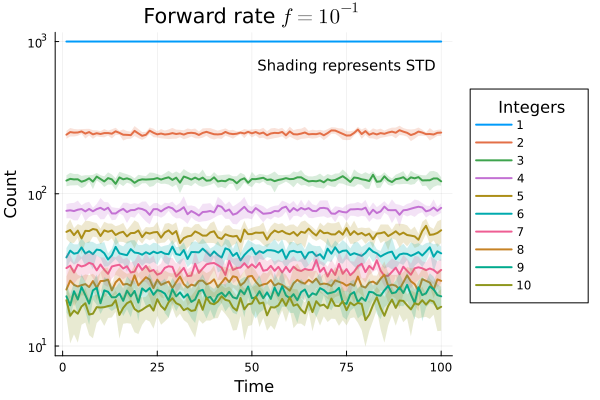

"/Users/alexandre/Documents/academic/2-research/projects/2023 spatial-topology/flow-complexity/milestones/figs/pop_f=1e-1.pdf"

In [17]:
using Plots
using LaTeXStrings

p = plot(title="Forward rate " * L"f=10^{-1}", xlabel="Time", ylabel="Count", yaxis=:log10, legendtitle="Integers", legend=:outerright)

palette = cgrad(:viridis, nspecies)

for i in 1:nspecies
    pop_avg = pop_avg_array[:, i]
    pop_std = pop_std_array[:, i]
    plot!(p, 1:max_t, pop_avg, lw=2, ribbon=pop_std, fillalpha=0.2, label="$i")
end

annotate!(75,700, text("Shading represents STD", :black, 10))

display(p)

savefig("./figs/pop_f=1e-1.pdf")